In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag_Dual(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU((lag+1) * 2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V1, V2):
        #V is shape (batch, 50000, lag+1)
        V = torch.cat([V1, V2], -1)
        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out).reshape(V.shape[0], -1) #(batch*50000,1)
        
        return lin_out

In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 0.2)
H_no = 40
device = torch.device("cuda:2")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)
#V = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/V_comb_pred_dend_interact_0.2ms.npy").reshape(-1,batch_length)
V1 = np.load("/scratch/yjk27/CA1_clust4-60_AP/diff_pred/V_diff_pred_joint_0.2ms.npy").reshape(-1,batch_length)
V2 = np.load("/scratch/yjk27/CA1_clust4-60_AP/nona_pred/V_nona_pred_0.2ms.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/V_whole_pred_0.2ms.npy").reshape(-1,batch_length)
S = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V1-= np.mean(V1)
V2-= np.mean(V2)

V1 = torch.from_numpy(V1)
V2 = torch.from_numpy(V2)
S = torch.from_numpy(S)

V1_lag = np.zeros((V1.shape[0], V1.shape[1], lag)) #(lag,1000,50000)
V2_lag = np.zeros((V2.shape[0], V2.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V1_lag[:,i+1:,i] = V1[:,:-i-1]
    V2_lag[:,i+1:,i] = V2[:,:-i-1]

V1_lag = torch.from_numpy(V1_lag)
V2_lag = torch.from_numpy(V2_lag)
print(V1_lag.shape)

torch.Size([1000, 50000, 20])


In [4]:
V1_train = V1[:980].float()
V1_test = V1[980:].float().to(device)
V2_train = V2[:980].float()
V2_test = V2[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V1_lag_train = V1_lag[:980].float()
V1_lag_test = V1_lag[980:].float().to(device)
V2_lag_train = V2_lag[:980].float()
V2_lag_test = V2_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag_Dual(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

10121


In [6]:
#model.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V.pt",
                     #map_location=device))

In [7]:
score_list = []

#for i in tnrange(iter_no):
for i in tnrange(10000):    
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V1 = V1_train[batch_idx].to(device)
    batch_V1_lag = V1_lag_train[batch_idx].to(device)
    batch_V2 = V2_train[batch_idx].to(device)
    batch_V2_lag = V2_lag_train[batch_idx].to(device)
    
    batch_V1_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V1_in[:,:,0] = batch_V1
    batch_V1_in[:,:,1:] = batch_V1_lag
    batch_V2_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V2_in[:,:,0] = batch_V2
    batch_V2_in[:,:,1:] = batch_V2_lag
    
    S_out = model(batch_V1_in, batch_V2_in)
    loss = torch.mean((S_out - batch_S) ** 2)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V1_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V1_test_in[:,:,0] = V1_test
        V1_test_in[:,:,1:] = V1_lag_test
        V2_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V2_test_in[:,:,0] = V2_test
        V2_test_in[:,:,1:] = V2_lag_test
        
        test_S_out = model(V1_test_in, V2_test_in)
        test_loss = torch.mean((S_test - test_S_out) ** 2)
        test_var_exp = explained_variance_score(S_test.flatten().cpu().detach().numpy(),
                                                test_S_out.flatten().cpu().detach().numpy())
        
        score_list.append(test_loss.item())
        print(i, test_loss.item(), test_var_exp)

<ipython-input-7-99282bbeba95>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 10.037708282470703 -0.00410008430480957
49 9.617646217346191 0.02296900749206543
99 9.502517700195312 0.03460276126861572
149 9.290650367736816 0.05628681182861328
199 9.112425804138184 0.07438546419143677
299 8.69867992401123 0.11632782220840454
349 8.46158218383789 0.14046502113342285
399 8.422686576843262 0.1443578600883484
449 8.268040657043457 0.16017389297485352
499 8.138729095458984 0.1733241081237793
549 8.115742683410645 0.1754729151725769
599 8.585147857666016 0.12783199548721313
649 8.030162811279297 0.18426352739334106
699 7.951931953430176 0.19236528873443604
749 7.895026683807373 0.1979539394378662
799 8.160423278808594 0.17102175951004028
849 7.773869514465332 0.2102460265159607
899 7.814200401306152 0.20614737272262573
949 7.716206073760986 0.21610283851623535
999 7.686069011688232 0.21920323371887207
1049 7.902123928070068 0.19727027416229248
1099 7.619833946228027 0.22593671083450317
1149 7.794705867767334 0.20814871788024902
1199 7.682327747344971 0.219523608684539

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3949 6.773406028747559 0.31196510791778564
3999 6.807363033294678 0.30839890241622925
4049 6.851992130279541 0.3038991689682007
4099 6.739933013916016 0.3156449794769287
4149 6.8232951164245605 0.3068962097167969
4199 7.149559497833252 0.27420371770858765
4249 6.824048042297363 0.3067764639854431
4299 6.694357872009277 0.319916307926178
4349 6.666090965270996 0.32275211811065674
4399 6.810659885406494 0.3080828785896301
4449 6.731027126312256 0.316353976726532
4499 6.704054355621338 0.3188963532447815
4549 6.696178913116455 0.3197699785232544
4599 6.701539039611816 0.3195897936820984
4649 6.668280601501465 0.32260626554489136
4699 6.745532035827637 0.31468451023101807
4749 6.838171482086182 0.3053510785102844
4799 6.873635768890381 0.3016802668571472
4849 6.6959991455078125 0.3197714686393738
4899 6.620993614196777 0.3274620771408081
4949 6.771180629730225 0.3123801350593567
4999 6.693602085113525 0.3201294541358948
5049 6.757315158843994 0.31357961893081665
5099 6.7147979736328125 0.3

KeyboardInterrupt: 

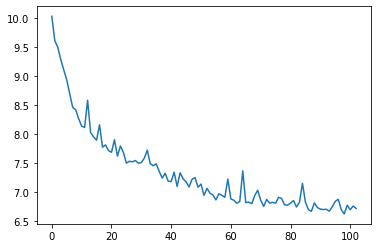

In [8]:
plt.plot(np.asarray(score_list)[:])


tensor(44.6218, device='cuda:2', grad_fn=<MaxBackward1>)


(23000.0, 28000.0)

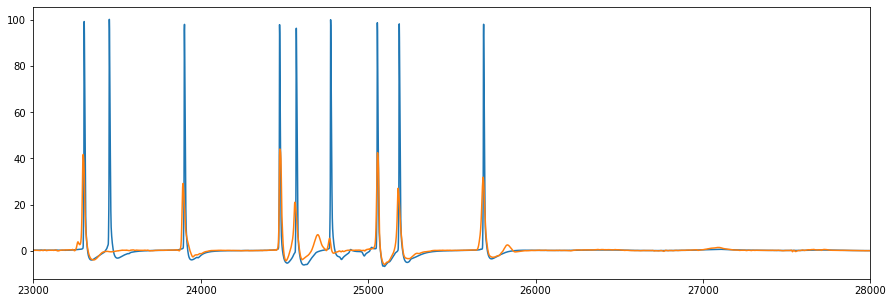

In [9]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[0].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))
plt.xlim(23000,28000)

In [10]:
test_S_out = test_S_out.cpu().detach().numpy()
test_S_out_next = np.zeros_like(test_S_out)
test_S_out_next[:,:-1] = test_S_out[:,1:]
test_S_out_thresh = np.zeros_like(test_S_out)

thresh = 15

for i in range(test_S_out.shape[0]):
    idx = np.where((test_S_out[i] < thresh) & (test_S_out_next[i] >= thresh))[0]
    test_S_out_thresh[i][idx] = 1

In [11]:
print(np.sum(test_S_out_thresh))

167.0


In [11]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_V_joint.pt")

In [12]:
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V_joint.npy", test_S_out)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_S_joint.npy", test_S_out_thresh)